# Analysis of Steam app reviews on Play Market
## The report is located at the very bottom, after the code⬇️

# All libraries

In [13]:
import pandas as pd
import numpy as np
from numpy import arange

import matplotlib.pyplot as plt

from google_play_scraper import Sort, reviews

import warnings
import datetime
import string
import pprint
import random

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.text import Text

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import confusion_matrix as cm

# Attributes

In [14]:
WNlemma = nltk.WordNetLemmatizer()

In [15]:
remove_list = set(stopwords.words('english') + list(string.punctuation) + list(string.digits) + list(string.ascii_lowercase))

In [16]:
warnings.filterwarnings("ignore")

# Functions

In [17]:
def tokenize(string):
    return [word.lower() for word in word_tokenize(string)]   

In [18]:
# remove stopwords and punctuations
def clear(tokens):
    return [token for token in tokens if token not in remove_list]

In [19]:
# from word to its lemma
def lemmatize(tokens):
    return [WNlemma.lemmatize(token) for token in tokens]

In [20]:
# extractacs most popular tokens from the list of strings, size defined
def popular_strings_tokens(strings, size = 200, display = False, graph_size = 50):
    all_tokens = []
    
    for string in strings:
        tokens = lemmatize(clear(tokenize(string)))
        all_tokens.extend(tokens)
        
    fdist = FreqDist(all_tokens)
    
    if display: # if you want to see the graph
        plt.figure(figsize = (16, 7))
        fdist.plot(graph_size)
        plt.show()
    
    return fdist.most_common(min(size, len(fdist)))    

In [21]:
# creates dataframe from list of strings as records and list of tokens as features
# binary values, 1 if token appears in the string, 0 if not
def create_database_tokens(strings, selected_tokens):
    features = {}
    for token in selected_tokens:
        features[token] = []
        
    for string in strings:
        tokens = lemmatize(clear(tokenize(string)))
        
        for feature in features:
            if feature in tokens:
                features[feature].append(1)
            else:
                features[feature].append(0)
    
    return pd.DataFrame(features, columns = features.keys())

In [22]:
# returns what portion of data is covered by the list of the selected features
def total_appear(feature_list, dataset, perc = True):
    cnt = 0
    
    for i in dataset.index:
        for feature in feature_list:
            if dataset[feature][i] == 1:
                cnt += 1
                break
    
    if perc: # if you want to see the portion
        return round(cnt / len(dataset), 2)
    
    else: # if you want to see the whole number
        return cnt

# Importing reviews

In [23]:
# importing 5000 newest reviews
rvs, _ = reviews('com.valvesoftware.android.steam.community', lang = 'en', country = 'uk', sort = Sort.NEWEST,
                 count = 5000)

In [24]:
print(f'the earliest comment in the dataset dates to {rvs[-1]["at"]}')

the earliest comment in the dataset dates to 2021-04-17 00:59:33


In [25]:
# putting data in proper format, list by list
features = {'content': [], 'score': [], 'time': [], 'thumbs': []}

last_update = datetime.datetime(2021, 6, 1, 23, 59, 59)

for review in rvs:
    if review['at'] < last_update or not review['content']: # if the review is outdated
        continue
        
    features['content'].append(review['content'])
    features['score'].append(review['score'])
    features['time'].append(review['at'])
    features['thumbs'].append(review['thumbsUpCount'])

In [26]:
raw_data = pd.DataFrame(features)

In [27]:
raw_data.tail()

,content,score,time,thumbs
4389,Don't use the mobile version 😠 Doesn't even op...,1,2021-06-02 03:53:47,0
4390,No account setting. Can't view my wallet,1,2021-06-02 03:32:24,0
4391,"Latest update removed the Wishlist, Follow, an...",1,2021-06-02 02:39:05,0
4392,Add to wishlist is gone from the app in the la...,1,2021-06-02 01:10:49,0
4393,Its good for pc but does nothing on mobile tab...,4,2021-06-02 00:38:59,0


In [28]:
# calculating the number of reviews for each score
score_cnt = dict(raw_data['score'].value_counts())
score_cnt = dict(sorted(score_cnt.items()))

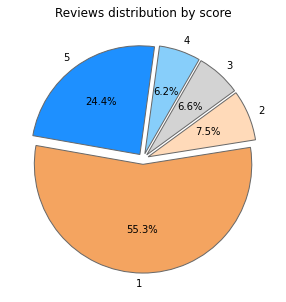

In [29]:
fig1 = plt.figure(figsize = (5, 5))
plt.pie(x = score_cnt.values(), labels = score_cnt.keys(), autopct = '%1.1f%%',
       explode = [0.05 for _ in range(5)], wedgeprops = {'edgecolor': 'dimgrey'}, startangle = 170,
        colors = ['sandybrown', 'peachpuff', 'lightgrey', 'lightskyblue', 'dodgerblue'])
plt.title('Reviews distribution by score')
plt.show()

# Some descriptive analysis of data

In [30]:
# obtaining date of each review in format of year, month
yearmonth = []

for date in raw_data['time']:
    year = date.date().year
    month = date.date().month
    yearmonth.append((year, month))
    
raw_data['yearmonth'] = yearmonth

In [31]:
# calculating average review count and average score for each month
uniq_yearmonth = sorted(list(set(yearmonth)))[: -1] #We don`t include the last month, as it`s not full

monthly_count = []
monthly_score = []

for ym in uniq_yearmonth:
    month_data = raw_data['score'][raw_data['yearmonth'] == ym]
    monthly_count.append(month_data.count())
    monthly_score.append(month_data.mean())

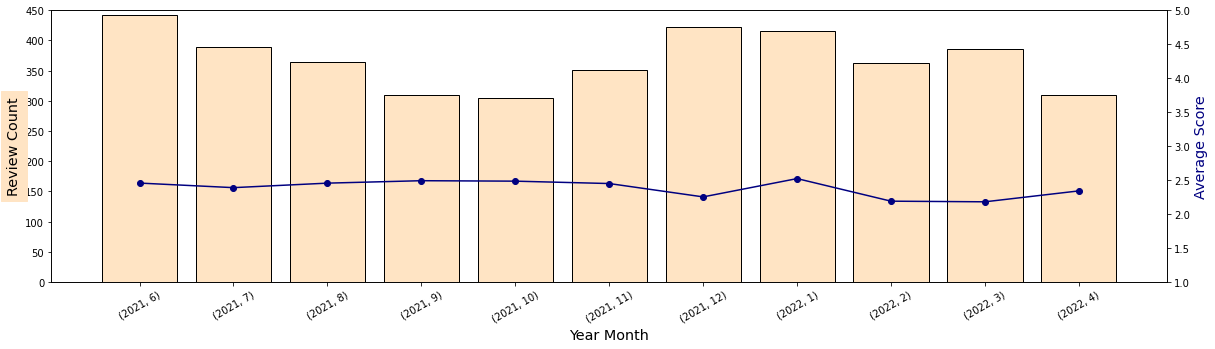

In [32]:
fig2, ax1 = plt.subplots(figsize = (20, 5))
ax2 = ax1.twinx()

ax1.bar(x = range(len(uniq_yearmonth)), height = monthly_count, align = 'center', color = 'bisque',
        edgecolor = 'black')
ax2.plot(monthly_score, color = 'navy', marker = 'o')

ax1.set_xlabel('Year Month', fontsize = 'x-large')
ax1.set_ylabel('Review Count', color = 'black', backgroundcolor = 'bisque', fontsize = 'x-large')
ax2.set_ylabel('Average Score', color = 'navy', fontsize = 'x-large')

ax1.set_ylim(0, 450)
ax2.set_ylim(1, 5)

ax1.set_xticks(range(len(uniq_yearmonth)))
ax1.set_xticklabels(uniq_yearmonth, rotation = 30)
plt.show()

In [33]:
# calculating the portion of comments for each score
review_size = {}

for score in range(1, 6):
    summ = 0
    n = 0
    
    for review in raw_data['content'][raw_data['score'] == score]:
        words = tokenize(review)
        summ += len(words)
        n += 1
        
    review_size[score] = summ // n

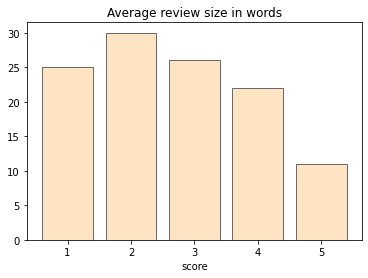

In [34]:
fig3 = plt.figure()
plt.bar(x = review_size.keys(), height = review_size.values(), align = 'center', color = 'bisque', edgecolor = 'dimgray')
plt.xlabel('score')
plt.title('Average review size in words')
plt.show()

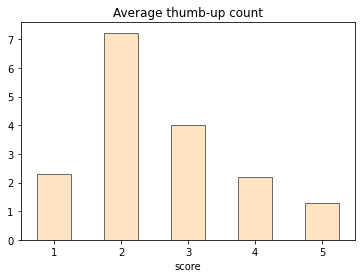

In [35]:
fig4 = plt.figure()
raw_data.groupby('score').mean()['thumbs'].plot(kind = 'bar', rot = 0, color = 'bisque', edgecolor = 'dimgray')
plt.title('Average thumb-up count')
plt.show()

# Sentiment analysis

In [36]:
# calculating sentiment score by Vader
vader_score = []

for line in raw_data['content']:
    sentences = sent_tokenize(line)
    line_score = 0
    
    for sentence in sentences:
        line_score += SIA().polarity_scores(sentence)['compound']
    
    vader_score.append(line_score)

In [37]:
raw_data['vader_score'] = vader_score

In [38]:
# calculating sentiment score by SentiWordNet
swn_score = []

for line in raw_data['content']:
    line_score = 0
    words = word_tokenize(line)
    
    for word in words:
        word_neg, word_pos, word_n = 0, 0, 0
        syns_swn = swn.senti_synsets(word)
        
        for syn in syns_swn: # applying algorithm for each synonym of the word
            word_n += 1
            word_neg += syn.neg_score()
            word_pos += syn.pos_score()
        
        if not word_n:
            continue
            
        word_neg = word_neg / word_n 
        word_pos = word_pos / word_n # average for each synonym 
        
        line_score += round(word_pos - word_neg, 2) # difference of positive score and negative scores
    
    swn_score.append(line_score)

In [39]:
raw_data['swn_score'] = swn_score

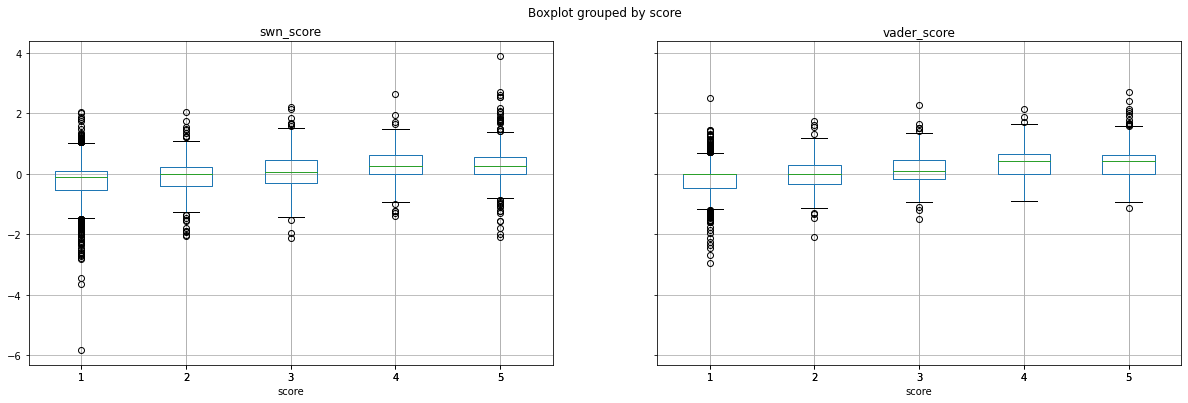

In [40]:
raw_data.boxplot(column = ['swn_score', 'vader_score'], by = 'score', figsize = (20, 6))
plt.show()

In [41]:
# all reviews with low review score but high sentiment score
low_high_comments = list(raw_data['content'][(raw_data['score'] < 3) & (raw_data['vader_score'] > 0.5) & (raw_data['swn_score'] > 0.5)])

In [42]:
# random sampling
low_high_sample = random.sample(low_high_comments, 5)
low_high_output = ''
for line in low_high_sample:
    low_high_output += line + '\n\n'

In [43]:
print(low_high_output)

this is one of the hardest apps to sign in to. It like signing up in this app is already a hard challenge since it just repeats and repeats on the sign in. It wont let me put on my username or a password. Please make signing up easier

This is NOT EASY TO USE LIKE DUDE YOU HAVE 2 MILLION BUTTONS ON YOUR SCREEN AND WHERE THE PHAK CAN YOU FIND RHW BUY BUTTON MAKING AN ACCOUNT IS HARD ENOUGH THEY DELETE YOUR EMAIL FROM THE INBOX LIKE THE 5 STAR REVIEWS ARE 1000000000000% BOTS STEAM IS THE BEST NAME FOR THIS, THIS APP JUST MAKES YOU STEAM LIKE CRAZY WORST APP EVER LIKE DUDE

App is absolute trash. Never was able to use it much due to all the security. Before you "well actually" me, know that mean meaningful security. Compare other app recovery processes to this one and ask yourself which one is better. This is the only app I have this kind of trouble with. Is there no preserve the save state instance while I pull up my email in anpther window? It takes me back to the login screen. Nullifie

In [44]:
# all reviews with high review score but low sentiment score
high_low_comments = list(raw_data['content'][(raw_data['score'] > 3) & (raw_data['vader_score'] < 0) & (raw_data['swn_score'] < 0)])

In [45]:
# random sampling
high_low_sample = random.sample(high_low_comments, 5)
high_low_output = ''
for line in high_low_sample:
    high_low_output += line + '\n\n'

In [46]:
print(high_low_output)

Please add Counter Strike Global Offensive in your android device

I've not faced any issues until today 04/05/22. The app blinked several times upon loading it up and then wanted me to sign in again. Not sure if thats a sign of someone trying to hack me and if I log in they will get access or not? So I uninstalled and now re installing. Just in case. Gave 5 star for ads shown in the app because there aren't any apart from steam game related ones I guess and discounts.

This is kinda stupid but, could you add the steam points store?

Game di steam ban

Worse than the pc app




In [51]:
high_low_ind = raw_data[(raw_data['score'] > 3) & (raw_data['vader_score'] < 0) & (raw_data['swn_score'] < 0)].index
low_high_ind = raw_data[(raw_data['score'] < 3) & (raw_data['vader_score'] > 0.5) & (raw_data['swn_score'] > 0.5)].index

# Correcting the database

In [52]:
# neglecting outliers and review of score 3
upd_data = raw_data[raw_data['score'] != 3].copy()
upd_data.drop(high_low_ind, axis = 0, inplace = True)
upd_data.drop(low_high_ind, axis = 0, inplace = True)
upd_data.reset_index(inplace = True, drop = True)

In [53]:
# labelling reviews
upd_data['mark'] = [-1 if score < 3 else 1 for score in upd_data['score']]

In [54]:
upd_data = upd_data[['content', 'mark', 'time', 'score', 'thumbs']]
upd_data.tail()

,content,mark,time,score,thumbs
3971,Don't use the mobile version 😠 Doesn't even op...,-1,2021-06-02 03:53:47,1,0
3972,No account setting. Can't view my wallet,-1,2021-06-02 03:32:24,1,0
3973,"Latest update removed the Wishlist, Follow, an...",-1,2021-06-02 02:39:05,1,0
3974,Add to wishlist is gone from the app in the la...,-1,2021-06-02 01:10:49,1,0
3975,Its good for pc but does nothing on mobile tab...,1,2021-06-02 00:38:59,4,0


In [55]:
# calculating the number of reviews for each score and label
score_cnt = dict(upd_data['score'].value_counts())
score_cnt = dict(sorted(score_cnt.items()))

mark_cnt = dict(upd_data['mark'].value_counts())
mark_cnt = dict(sorted(mark_cnt.items()))

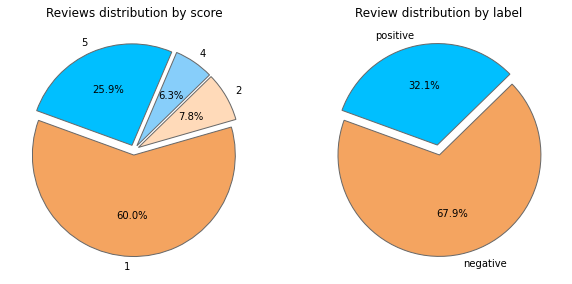

In [56]:
fig6 = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.pie(x = score_cnt.values(), labels = score_cnt.keys(), autopct = '%1.1f%%',
       explode = [0.05 for _ in range(4)], colors = ['sandybrown', 'peachpuff', 'lightskyblue', 'deepskyblue'],
       wedgeprops = {'edgecolor': 'dimgrey'}, startangle = 160)
plt.title('Reviews distribution by score')
plt.subplot(1, 2, 2)
plt.pie(x = mark_cnt.values(), labels = ['negative', 'positive'], autopct = '%1.1f%%',
       explode = [0.05 for _ in range(2)], colors = ['sandybrown', 'deepskyblue'],
       wedgeprops = {'edgecolor': 'dimgrey'}, startangle = 160)
plt.title('Review distribution by label')
plt.show()

In [57]:
len(upd_data)

3976

# Remove list

In [58]:
# adding some elements for remove list
for each in ["n't", "'s", "ca", "'ve", '...', '``', "''", "'m", 'wo', '..', '....', '....', "'ll", "'re", "'d"]:
    remove_list.add(each)

# Popular tokens

Appearance of popular tokens


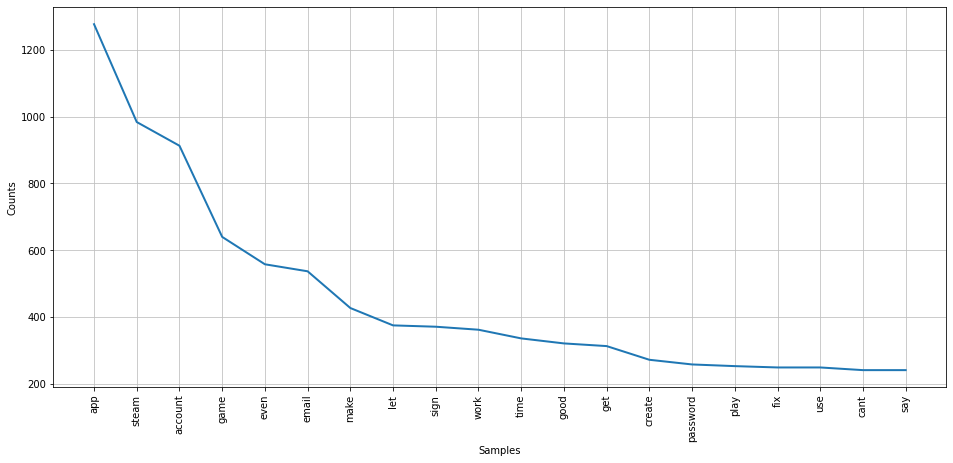

In [59]:
# 200 most frequent tokens among all reviews
print('Appearance of popular tokens')
popular_tokens = popular_strings_tokens(upd_data['content'], 200, True, 20)

In [65]:
# separating popular tokens from their frequency
popular_just_tokens = [token for (token, freq) in popular_tokens]

# Classification models

In [66]:
# prepearing data for classification
# x is features, y is the labels to predict
x = create_database_tokens(upd_data['content'], popular_just_tokens)
y = upd_data['mark']

### Naive Bayes

In [67]:
nb = GaussianNB()
nb.fit(x, y)
y_nb = nb.predict(x)

In [68]:
matrix_nb = cm(y, y_nb)
print('confusion matrix:\n', matrix_nb)

confusion matrix:
 [[1623 1075]
 [  62 1216]]


In [69]:
accuracy_nb = accuracy_score(y, y_nb)
specificity_nb = matrix_nb[0][0] / (matrix_nb[0][0] + matrix_nb[0][1])

In [70]:
print('accuracy =', accuracy_nb)
print('specificity =', specificity_nb)

accuracy = 0.7140342052313883
specificity = 0.6015567086730912


### Lasso Logistic

In [71]:
las_log = LogisticRegression(penalty = 'l1', solver = 'liblinear', max_iter = 1000)
parameters = {'C': arange(0.0001, 1, 0.001)}
lasso_search = GridSearchCV(las_log, parameters, scoring = 'balanced_accuracy')
lasso_search.fit(x, y)
print(lasso_search.best_estimator_)

LogisticRegression(C=0.7681, max_iter=1000, penalty='l1', solver='liblinear')


In [72]:
y_lasso = lasso_search.predict(x)
matrix_lasso = cm(y, y_lasso)
print('confusion matrix:\n', matrix_lasso)

confusion matrix:
 [[2413  285]
 [ 237 1041]]


In [73]:
accuracy_lasso = accuracy_score(y, y_lasso)
specificity_lasso = matrix_lasso[0][0] / (matrix_lasso[0][0] + matrix_lasso[0][1])

In [74]:
print('accuracy =', accuracy_lasso)
print('specificity =', specificity_lasso)

accuracy = 0.8687122736418511
specificity = 0.8943661971830986


### Decision Tree

In [75]:
parameters = {'min_samples_leaf':arange(5, 20, 1), 'max_depth': list(arange(5, 20, 1))}
tree_search = GridSearchCV(DecisionTreeClassifier(random_state = 17), parameters, scoring = 'balanced_accuracy')
tree_search.fit(x, y)
tree_search.best_estimator_

DecisionTreeClassifier(max_depth=16, min_samples_leaf=10, random_state=17)

In [76]:
y_tree = tree_search.predict(x)
matrix_tree = cm(y, y_tree)
print('confusion matrix:\n', matrix_tree)

confusion matrix:
 [[2606   92]
 [ 731  547]]


In [99]:
accuracy_tree = accuracy_score(y, y_tree)
specificity_tree = matrix_tree[0][0] / (matrix_tree[0][0] + matrix_tree[0][1])

In [100]:
print('accuracy =', accuracy_tree)
print('specificity =', specificity_tree)

accuracy = 0.7930080482897385
specificity = 0.9659006671608599


### Random Forest

In [79]:
parameters = {'n_estimators': arange(20, 100, 10), 'max_depth': arange(5, 20, 1), 'criterion': ['gini', 'entropy']}
forest_search = GridSearchCV(RandomForestClassifier(random_state = 17, max_features = 'sqrt', min_samples_leaf = 1),
                          parameters, scoring = 'balanced_accuracy')
forest_search.fit(x, y)
forest_search.best_estimator_

RandomForestClassifier(max_depth=19, max_features='sqrt', n_estimators=60,
                       random_state=17)

In [80]:
y_forest = forest_search.predict(x)
matrix_forest = cm(y, y_forest)
print('confusion matrix:\n', matrix_forest)

confusion matrix:
 [[2678   20]
 [ 648  630]]


In [88]:
accuracy_forest = accuracy_score(y, y_forest)
specificity_forest = matrix_forest[0][0] / (matrix_forest[0][0] + matrix_forest[0][1])

In [89]:
print('accuracy =', accuracy_forest)
print('specificity =', specificity_forest)

accuracy = 0.8319919517102615
specificity = 0.9925871015567087


### Ada boost

In [82]:
parameters = {'n_estimators':arange(20, 100, 5)}
ada = AdaBoostClassifier(random_state = 17)
ada_search = GridSearchCV(ada, parameters, scoring = 'balanced_accuracy')
ada_search.fit(x, y)
ada_search.best_estimator_

AdaBoostClassifier(n_estimators=75, random_state=17)

In [83]:
y_ada = ada_search.predict(x)
matrix_ada = cm(y, y_ada)
print('confusion matrix:\n', matrix_ada)

confusion matrix:
 [[2302  396]
 [ 202 1076]]


In [90]:
accuracy_ada = accuracy_score(y, y_ada)
specificity_ada = matrix_ada[0][0] / (matrix_ada[0][0] + matrix_ada[0][1])

In [91]:
print('accuracy =', accuracy_ada)
print('specificity =', specificity_ada)

accuracy = 0.8495975855130785
specificity = 0.8532246108228317


### SVM

In [85]:
parameters = {'C': arange(0.1, 1.1, 0.1)}
svm_search = GridSearchCV(SVC(kernel = 'linear'), parameters, scoring = 'balanced_accuracy')
svm_search.fit(x, y)
print(svm_search.best_estimator_)

SVC(C=0.9, kernel='linear')


In [86]:
y_svm = svm_search.predict(x)
matrix_svm = cm(y, y_svm)
print('confusion matrix:\n', matrix_svm)

confusion matrix:
 [[2431  267]
 [ 231 1047]]


In [92]:
accuracy_svm = accuracy_score(y, y_svm)
specificity_svm = matrix_svm[0][0] / (matrix_svm[0][0] + matrix_svm[0][1])

In [93]:
print('accuracy =', accuracy_svm)
print('specificity =', specificity_svm)

accuracy = 0.8747484909456741
specificity = 0.9010378057820608


In [127]:
# aggregaring accuracies
accuracies = [accuracy_nb, accuracy_lasso, accuracy_tree, accuracy_forest, accuracy_ada, accuracy_svm]
accuracies = [round(acc * 100, 2) for acc in accuracies]

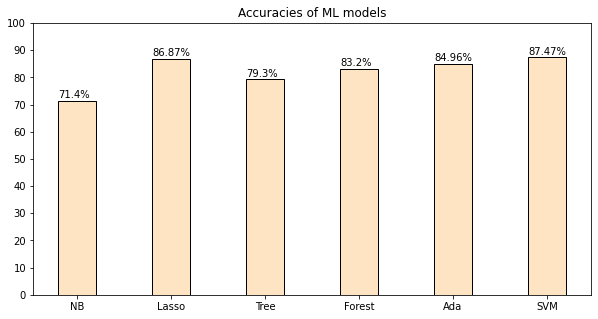

In [159]:
fig8 = plt.figure(figsize = (10, 5))
plt.bar(x = arange(1, 7), height = accuracies, width = 0.4, color = 'bisque', edgecolor = 'black')
plt.xticks(ticks = arange(1, 7), labels = ['NB', 'Lasso', 'Tree', 'Forest', 'Ada', 'SVM'])
plt.yticks(ticks = range(0, 101, 10))
for i, acc in zip(range(1, 7), accuracies):
    plt.text(i - 0.2, acc + 1, str(acc) + '%')
plt.title('Accuracies of ML models')

plt.show()

# Results analysis

In [152]:
# extracting feature importance
feature_importances = [(x.columns[i], svm_search.best_estimator_.coef_[0][i]) for i in range(len(x.columns))]
feature_importances.sort(reverse = False, key = lambda x: x[1])
feature_importances = dict(feature_importances)

In [136]:
feature_importances

{'horrible': -1.8,
 'broken': -1.7766830774326239,
 'install': -1.6535394920049211,
 'open': -1.6240142531553183,
 'hate': -1.6165793764069907,
 'stupid': -1.6019108249480465,
 'suck': -1.5486419534334073,
 'worst': -1.4964258645596402,
 'even': -1.287113829509682,
 'trying': -1.2803090554790542,
 'terrible': -1.2795515169014988,
 'useless': -1.252906722039727,
 'captcha': -1.252904853890045,
 'garbage': -1.2527469790794918,
 'log': -1.2526809471687033,
 'join': -1.2526131098430215,
 'trash': -1.2525782076577188,
 'working': -1.2525324430650961,
 'bad': -1.252444487054785,
 'sign': -1.2523791617991904,
 'error': -1.2516536563587732,
 'password': -1.2262903485530217,
 'tried': -1.152405191859573,
 'hard': -1.120024052436241,
 'guard': -1.1010743395493883,
 'invalid': -1.0905588762408192,
 'login': -1.0762137834753323,
 'support': -1.0561241252259945,
 'fix': -1.0543911715194518,
 'cant': -1.0101589096069667,
 'create': -0.9851233310067719,
 'still': -0.9811154509910959,
 'email': -0.909

In [153]:
# manually sorting potentially insightful words
selected_features = ['open', 'error', 'working', 'join', 'log', 'captcha', 'sign', 'fix', 'password', 'login',
                     'point', 'support', 'right', 'invalid', 'continue', 'incorrect', 'sent', 'guard', 'ui',
                     'create', 'verification', 'screen', 'time', 'email', 'signing', 'service', 'robot', 'payment',
                     'downloaded', 'download', 'installed', 'reset', 'account', 'money', 'code', 'user', 'acc']

In [138]:
len(selected_features)

37

In [163]:
# for convenience creating dataframe only with the selected features
x_selected = create_database_tokens(upd_data['content'], selected_features)
x_selected['score'] = upd_data['score']

In [164]:
# counting appearance of selected features in negative reviews
appearances = {}

for feature in selected_features:
    appearances[feature] = x_selected[feature][x_selected['score'] < 3].sum()

In [165]:
# sorting appearances in decreasing order
appearances = sorted(appearances.items(), reverse = True, key = lambda x: x[1])
appearances = [feature for (feature, val) in appearances]

In [166]:
# calculating coverage of negative reviews by selected features
appearance_distribution = []

for i in range(1, len(selected_features) + 1):
    appearance_distribution.append(total_appear(appearances[: i], x_selected[x_selected['score'] < 3]))

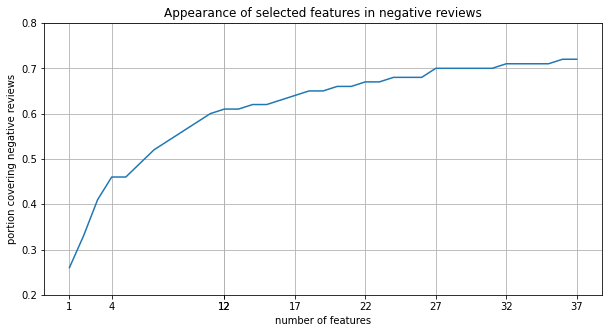

In [167]:
fig9 = plt.figure(figsize = (10, 5))
plt.plot(list(range(1, 38)), appearance_distribution)

plt.xlabel('number of features')
plt.ylabel('portion covering negative reviews')
plt.title('Appearance of selected features in negative reviews')

plt.xticks(ticks = [1, 4, 12] + list(range(12, 38, 5)))
plt.yticks(ticks = list(arange(0.2, 0.9, 0.1)))
plt.grid(visible = True)
plt.show()

In [168]:
# selecting only 12 words covering most of the negative reviews
short_list = appearances[:12]

In [169]:
short_list

['account',
 'email',
 'sign',
 'time',
 'create',
 'fix',
 'log',
 'password',
 'login',
 'code',
 'download',
 'guard']

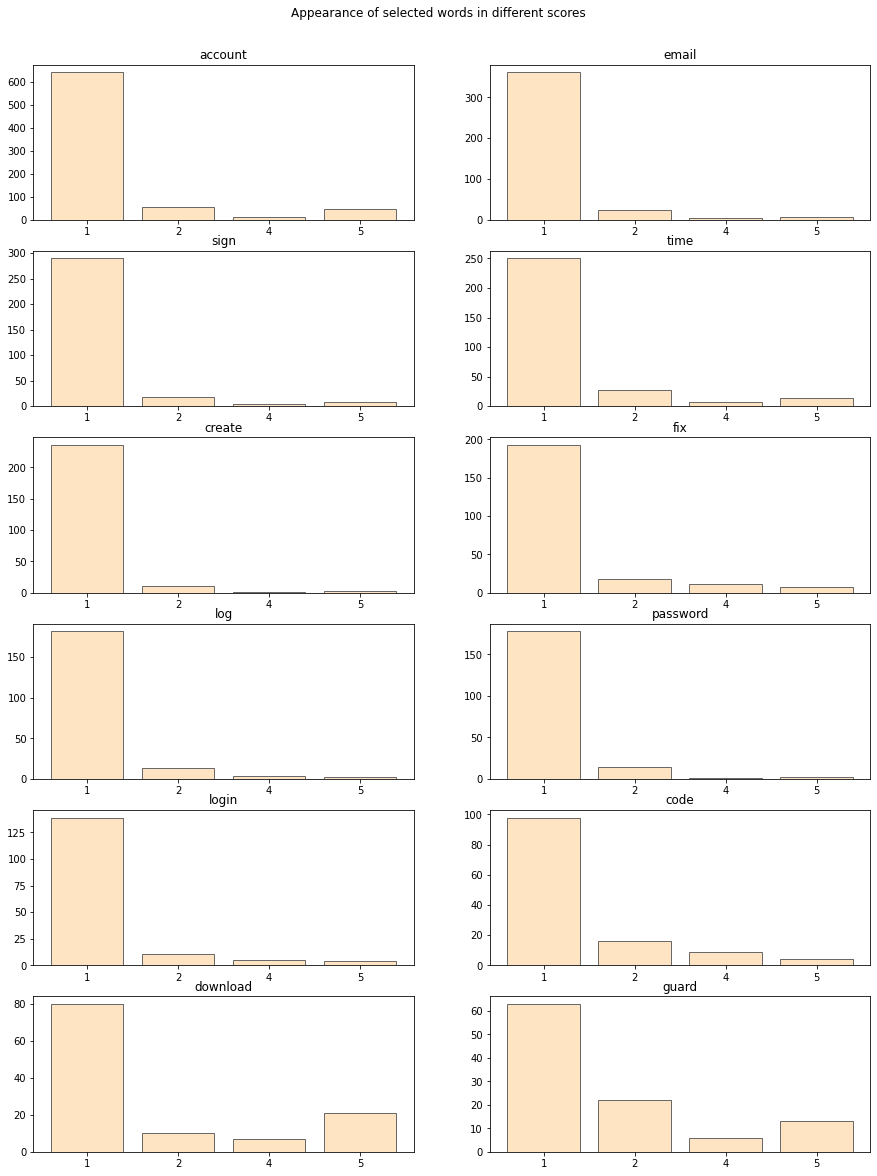

In [170]:
fig10 = plt.figure(figsize = (15, 20))

counter = 1

for feature in short_list:
    xs = [1, 2, 4, 5]
    feature_counts = []
    
    for i in xs:
        feature_counts.append(x_selected[feature][x_selected['score'] == i].sum())
        
    plt.subplot(6, 2, counter)
    plt.bar(x = [str(i) for i in xs], height = feature_counts, color = 'bisque', edgecolor = 'dimgrey')
    plt.title(feature)
    
    counter += 1
plt.suptitle('Appearance of selected words in different scores', y = 0.92)
plt.show()

### Feature context

In [171]:
x_selected['content'] = upd_data['content']

In [172]:
# reading random sample of reviews with each of the shorlisted features
for feature in short_list:
    print(f'CONTENT FOR \033[1m"{feature.upper()}"\033[0m:\n')
    
    feature_content = list(x_selected['content'][x_selected[feature] == 1])
    random_content = random.sample(feature_content, 10)
    
    for comment in random_content:
        print(comment)
        print()
    
    print('-------------------------------')
    

CONTENT FOR "ACCOUNT":

It won't let me make an account I put my email in there but nothing I have been doing this for 5hr help

Stuck in an infinite loop just trying to create an account. Join Steam > Email Verification > Submit email > check email and verify > email verified (you may close out so I do) > Email Verification > Submit email > check email and verify > ect ect Nothing sends me or allows me to go past Verification to account creation so I can create a password. The "help" options are useless and they provide no way to actually get any help unless you log in first.... which I cannot do due to he loop.

Can't create account

Somebody hack my account and this apps doesn't ask confirmation code scam apps mf creator 🖕🖕🖕

I was logging into steam I need to verify my email while getting an account but I verified it and it was still loading waiting

I apparantly have an invalid email so I can't create an account

I repeteafly enter the right code but it always said It's wrong like

### Valuable words

In [173]:
# removing uninformative words
for each in ['time', 'fix', 'download']:
    short_list.remove(each)

In [174]:
# calculating appearances of remaining words in positive and negative reviews
in_pos, in_neg, not_in_pos, not_in_neg = 0, 0, 0, 0

for i in range(len(x_selected)):
    appear = False
    
    for feature in short_list:
        if x_selected[feature][i] == 1:
            appear = True
            break
        
    if appear:
        if x_selected['score'][i] > 3:
            in_pos += 1
        else:
            in_neg += 1
            
    else:
        if x_selected['score'][i] > 3:
            not_in_pos += 1
        else:
            not_in_neg += 1
        

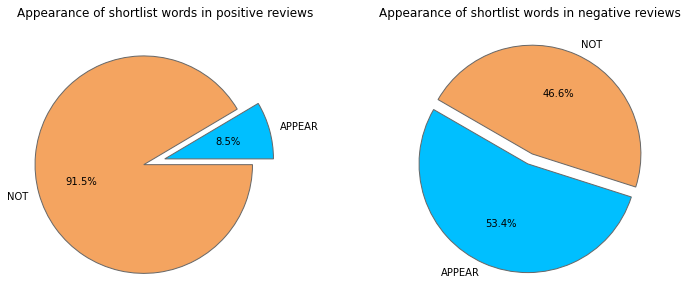

In [175]:
fig11 = plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.pie(x = [in_pos, not_in_pos], labels = ['APPEAR', 'NOT'], autopct = '%1.1f%%', explode = [0, 0.2],
        colors = ['deepskyblue', 'sandybrown'], wedgeprops = {'edgecolor': 'dimgrey'})
plt.title('Appearance of shortlist words in positive reviews')

plt.subplot(1, 2, 2)
plt.pie(x = [in_neg, not_in_neg], labels = ['APPEAR', 'NOT'], autopct = '%1.1f%%', explode = [0.05, 0.05],
       colors = ['deepskyblue', 'sandybrown'], wedgeprops = {'edgecolor': 'dimgrey'}, startangle = 150)
plt.title('Appearance of shortlist words in negative reviews')

plt.show()

# Report

What are the main issues of **Steam** app users expericne in Play Market. Let's find out.

#### Descriptive analysis

First, I have extracted newest 5000 customer reviews left in Play Market using **Google Play scrapper**.<br><br>
Among extracted reviews the earliest dates to 15th April of 2021, while the latest update was at 1st June of 2021. So, we are safe, 5000 was enough to include all comments relevant to new version. I then deleted all outdated reviews (before 1st June)<br><br>
After deleting, 4394 reviews left, mainly they have a score of 1, so the data was unballanced.

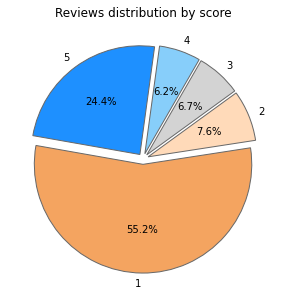

In [84]:
fig1

Let's take a look at trends through the time. The number of reviews per month fluctuated between 300 and 450. While the average monthly score didn't show significant changes, and kept around 2.5. Nothing much insightful, but worth checking out.

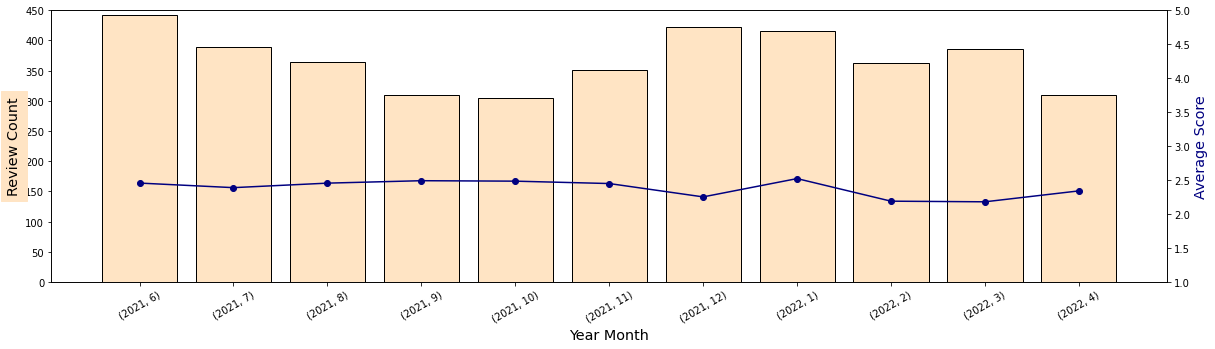

In [85]:
fig2

Reviews with score of **5** in average had significantly less (less than half) word count than each other score. That makes sense, as criticizing comments are more informative.<br><br>
Although reviews of score **2** took only small portion (~8%) of all data, they had in average highest thumb-up count, 7 per review. Meaning score 2 reviews are mainly up to point.

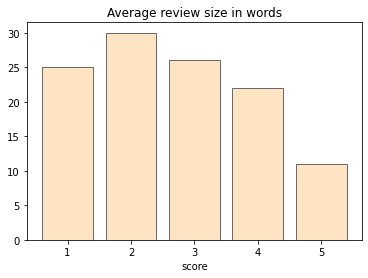

In [86]:
fig3

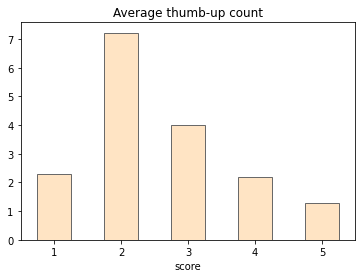

In [87]:
fig4

#### Strategy

The aim of this analysis is to obtain what are the main problems of the app. So we are going to classify bad and good reviews and see what drives this classification, that's the whole strategy. But here are the steps:
* First, we need to ensure that low scores really represent bad reviews, and accordingly high scores represent good reviews. This will be done by sentiment analysis.
* Next we need to label the reviews, i.e., bad or good, that's simply based on the scores that we validated in previous step
* Then we need to turn the words into features describing reviews
* Okay now we have features and labels, so the time to create ML models. It is crucial to use models than have an ability to extract feature importance. For this reason I have used Naive Bayes, Lasso Logistic Regression, Decision Tree, Random Forest, Ada Boost and linear Support Vector Machine.
* Then we are going to extract the feature importances (we secured before) from the best performing model. Reminding, that the features are just words, so we need to extract words that are apparently important for model and possibly insightful in context.
* Then we need to understand the meaning of selected features to gather insights.

#### Sentiment analysis

Sometimes users may leave scores inconsistent with the content of review. So, we need to check if the score really represented the sentiment of the review.<br><br>
All right, for the sentiment analysis I used two algorithms: **SentWordNet** and **Vader**. Both algorithms indicate sentiment of each word in a review and then average them to one value. Basically they just represent how negative or positive review is based on the appearance of words they classify as negative or positive. Since algorithms also outputs numeric score, to not confuse you, I will say **sentiment score** to one caluclated by algorithms and **review score** to one left by customer in review. 

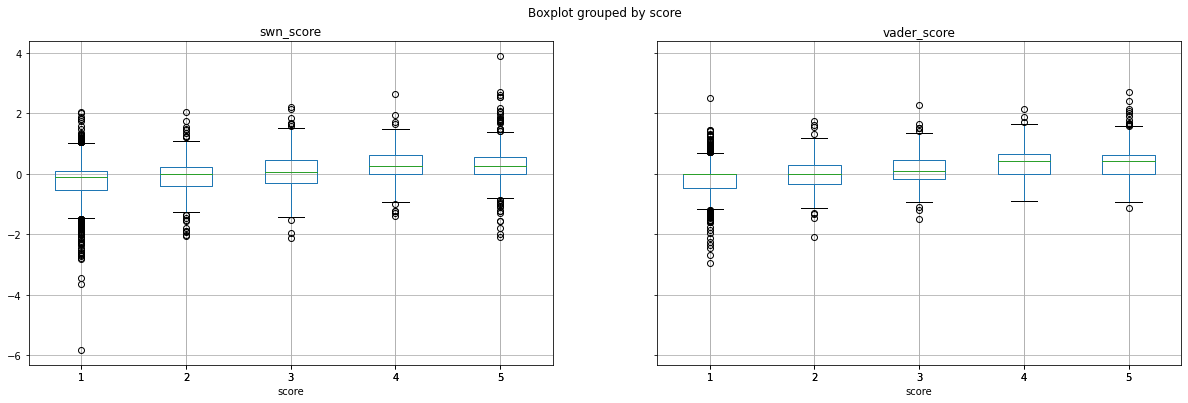

In [89]:
raw_data.boxplot(column = ['swn_score', 'vader_score'], by = 'score', figsize = (20, 6))
plt.show()

Fron the boxplot above we can see that with increase of sentiment score the review score increases as well, showing consistency. 2 rules can be emphasized from these boxplots, for both algorithms majority of:
1. Reviews with review score 1 and 2 had sentiment scores less than 0.5
1. Reviews with review score 4 and 5 had sentiment scores higher than 0

Still for these two rules above there were outliers. We are going to investigate them by looking at random sample. Here are random sample of reviews disobeying 1st rule:

In [134]:
print(low_high_output)

Please i want to buy my game and i dont know the reason why my bank always decline, please atleast let me know why my bank decline pleaseee

So recently I just got my account hacked and everything has been changed on it cuz when I tried to reset my password I didn't get the email from it I have games on that account I would like my account back please.😔that's why I'm giving a one star but if you could get my account back I would be happy to give it five stars. My username is killergirlgamerwolf. I would very much appreciate if you could help

Every time I enter my email and password, it tells me that one of them is wrong, but it won't tell me which. Much better on PC. This app needs improvement.

one star because i tryed to make a account but when i sayed that i am 16 years old nothing happend so i hope that this will make it better

So thought I would try out steam on my new tablet, Now I have a question. Is there only a special type of email that steam accepts??? I have tried all 4 o

Sample of reviews disobeying 2nd rule:

In [135]:
print(high_low_output)

I cant wait to play ddlc

The people having problems are using potatoes.

Bad app.

The Dewey Decimal System What a scam that was

its ok but laggy and annoying sometimes i dunno




From these sample it is clear two issues. Firstly, people may leave really bad review but still put good score and vice-versa. Secondly, some reviews were just poorly classified by SWN and Vader algorigthms. While the latter issue just showing underperformance of algorithms, the former may cause some problems. Including bad reviews labelled by high score will poorly train the model (garbage in, garbage out). So, for the sake of safety, reviews disobeying any of two rules were removed from the data.

In addition I found reviews with score 3 ambigous. By its nature it can be either good and bad evenly. So, to not confuse the model, reviews of score 3 were also removed.

After removal of outliers and score-3 reviews we left with 3976 records out of initial 4394, which is around 90%. So, we sacrifised a small portion (10%) of data to ensure proper feed of models.

#### Labelling reviews

Now, after pervious step of sentiment analysis it is easy to label reviews. We don't have score 3. According to obtained rules review score of 1 and 2 had low to negative sentiemnt score, thefore can be labelled as negative. For the same reason review score of 4 and 5 are the positive reviews. We may see that after all the data is still unballanced, 2 negative reviews to 1 positive.

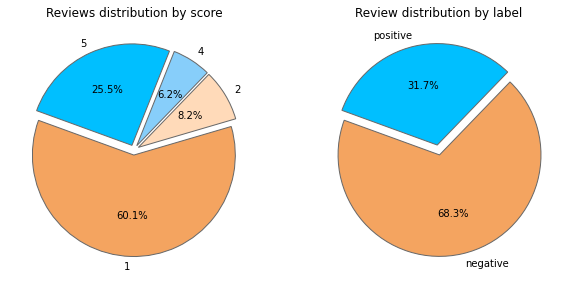

In [149]:
fig6

#### Feature creation

From all 3976 reviews I have extracted the most frequently used words. The words were filtered from stop words and punctuations, so we left only with more or less meaningful words. As a rule of thumb I wanted to create a dataframe of dimensions approximately 1:20, so for 3970 reviews 200 features were needed. Therefore I have taken top 200 frequently used words for our analysis. Here is the first 20 of them and their frequency.

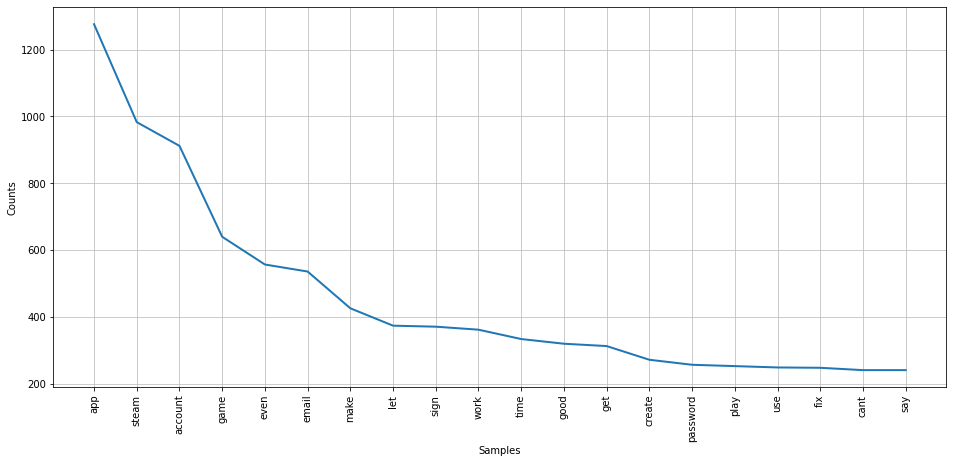

In [150]:
popular_tokens = popular_strings_tokens(upd_data['content'], 200, True, 20)

We may see that some of words are not that meaningful (like word **let**) or obvious (like **app**), but I am going to keep it for two reasons. Fristly, we don't know what words have predictive force, let the models work on it. Secondly, some of the words may just work as a control variables, meaning they may not be the main predictor, but catches the changes in data, that weren't caught by the main predictor.

So, these 200 words were converted into feature of reviews in such a way: if a word (let's say **game**) appearce in a review its feature (**game**) would be 1, alternatively 0. So, we have only binary values.

#### ML models

Previously I have mentioned that we are going to use 6 interpretable models. But, the tricky thing I am going to use them unusually.<br><br>Usually, we are training and testing model on different data, therefore making train-test split. Also, usually, we are making cross-validation during training. All this is done to avoid overfitiing the data, but we don't bother. We are not trying to extrapolate data, or predict score of future reviews, or preict score of other apps. We are trying to see what is going on with the specific app (Steam) at a specific period of time (since last update). Therefore we don't afraid of overfitting, but rather seeking it.

For the metric I used **balanced accuracy** to ensure models are trying to correctly predict both positive and negative reviews. As a result SVM achieved the best accuracy of 87.4%. 

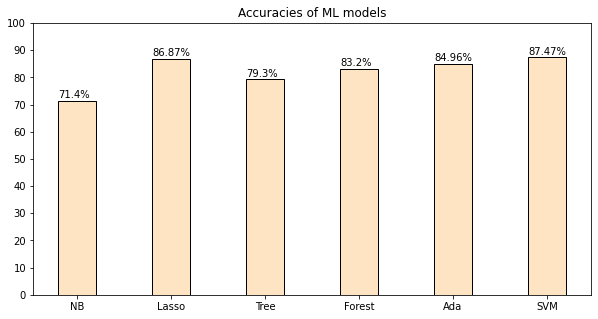

In [178]:
fig8

#### Feature importance

Since we used linear SVM it allows to extract coefficients of features it used for prediction. Since we are interested in features preicting negative reviews, we will look specifically at negative coefficients. Among them there were words like **horible** or **stupid**, their appearance is definitely a predictor of bad review, but they don't have much insights. On the other hand there were words like **install** or **captcha** with negative coefficient and potentially insightfull as well.<br><br>
So, among all features with negative score, I have manually selected 37 of them that have a potential to reveal something meaningful. Overall they are covering more than 70% of all negative reviews, but not evenly.<br><br>
As you may see below only first 4 features cover about 45% of all negative reviews, while first 12 features cover about 62%. Therefore it would not be wise to use all 37 features, when only 12 of them doing most of the work.

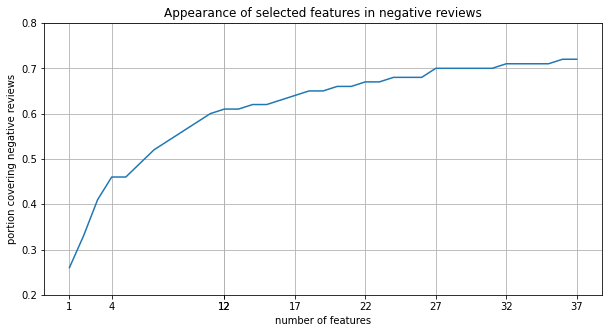

In [179]:
fig9

So, I have selected 12 features covering 62% of negative scores, what is next? We need to ensure that they are not covering majority of positive scores as well, otherwise they are just frequently appearing words, rather than predictors of bad reviews. Luckyly they are all distributed mainly in score 1 reviews

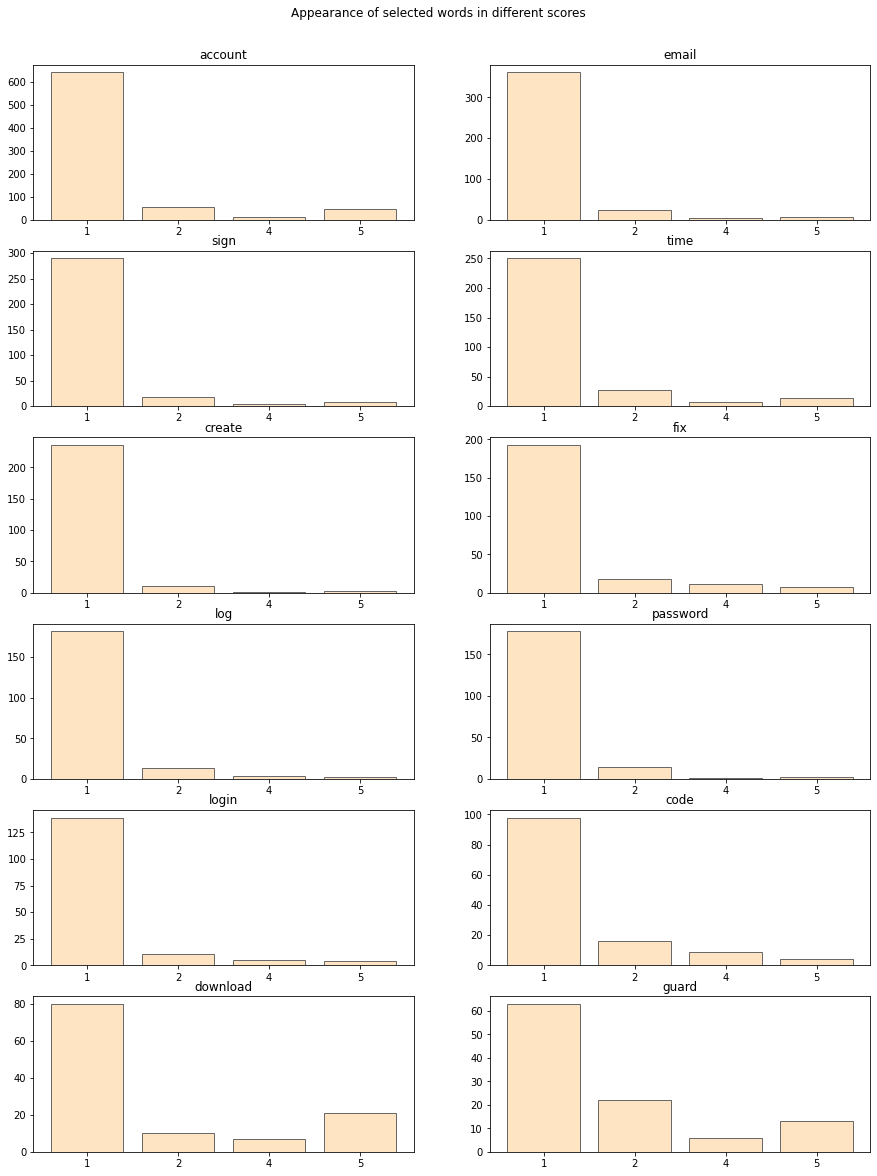

In [180]:
fig10

#### Context of selected features

The context of features were explored by directly looking at a sample of reviews contatining those features. As a result I revealed that word **time** is not that insightful, but used as a generic word like **every time** or **hundred times**. The word **fix** also appeared as a generic one, there were nothing specifically mentioned to fix. And the word **download** were mainly used as a recommendation to not download this app.

The rest 9 words were found to be more insightful and shared some few but common problems. Here is the main points of concern:
* It was difficult to create account: invalid email, infinite buffering time, restarts if minimize the app 
* It was difficult to log in the app: wrong password, steam guard not sending code, lost phone = no access
* It was difficult to reset the password: invalid email, no email verificaiton

So, now we can see how these 9 words represent the main problems of **Steam** app. Now we need to check what portion of neagtive reviews are covered by only those 9 words, and how often these 9 words appear in positive reviews.

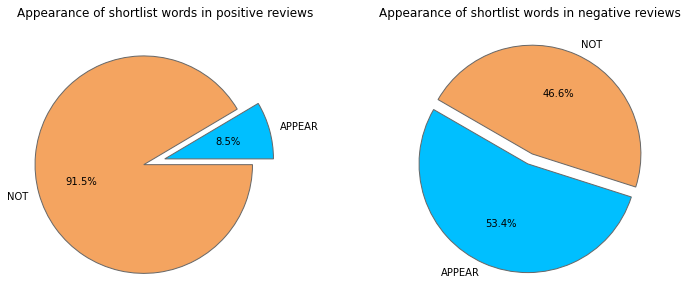

In [181]:
fig11

All right, now we see that there is insignificant appearance of selected words in positive reviews, while aggregatively they cover 53% of all negative reviews. From the whole analysis we can claim that half of negative reviews of mobile **Steam** app are related to **creation of account**, **log in to account** and **reseting the password**.